## This code takes the .npz file from TweetyBERT, as well as the surgery date from the bird's creation_data .json file, then color-codes data from pre versus post treatment (e.g. surgery, DOI injection).

To run quickly, adjust lines 5, 6 in the first cell to have the path to the .npz file from TweetyBERT and the json file with treatment dates, type, time, and recording dates.

### Load the .npz file and the .json file, extract the animal_id, treatment_date, and treatment_type (to be used in the graph titles later).

In [2]:
import re
import numpy as np
import json

# Paths to the .npz and .json files
path_to_npz_file_from_TweetyBERT = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_study/USA5506/USA5506_(10_mg_per_kg_DOI).npz'
path_to_json_file_with_dates = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_study/USA5506/DOI_USA5506_treatment_and_recording_dates.json'

# Use a regular expression to find the pattern 'USA' followed by 4 digits for the animal ID
match = re.search(r"(USA\d{4})", path_to_json_file_with_dates)
if match:
    animal_id = match.group(1)
    print(f"Animal ID: {animal_id}")
else:
    print("Animal ID not found in the file path.")

# Load the JSON file and extract the treatment date
with open(path_to_json_file_with_dates, 'r') as file:
    json_data = json.load(file)

# Extract and print the treatment date
treatment_date = json_data.get("treatment_date", "Treatment date not found")
treatment_type = json_data.get("treatment_type", "Treatment type not found")
print(f"Treatment Date: {treatment_date}")
print(f"Treatment Type: {treatment_type}")



Animal ID: USA5506
Treatment Date: 2024-10-28
Treatment Type: DOI 10 mg/kg


## Adjust the dictionary to include the date of the recording. 
### This is done by splitting up the name of the file into each segment divided by underscores. For example, USA5506_45589.62038161_10_24_17_13_58 is turned into a list of values: [USA5506, 45589.62038161, 10, 24, 17, 13, 58]. Python starts "counting" elements in the list at 0, so the 0th element is USA5506. The month value is the 2nd element in the list, the date is the 3rd elemement in the list, the hour is the 4th, etc. (see lines 39-42 of the cell).
### Then, I use the numpy module's datetime format to convert these numbers to a date and time value that I can store and find later (see lines 68-71).
### These datetimes are stored in the file_map_dictionary, so I can sort data based on the date it was generated (e.g. pre or post DOI date).

In [3]:
import numpy as np
import json

# # Paths to the files
# path_to_npz_file_from_TweetyBERT = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508.npz'
# path_to_json_file_with_dates = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508_creation_data.json'

# Load the .npz file
data = np.load(path_to_npz_file_from_TweetyBERT, allow_pickle=True)

# Extract the dictionary
file_map_dictionary = data['file_map'].item()

# Load the creation_data.json
with open(path_to_json_file_with_dates, 'r') as json_file:
    creation_data = json.load(json_file)

# Extract the year from 'treatment_date'
treatment_date = creation_data.get('treatment_date')
if treatment_date is None:
    raise ValueError("Treatment date not found in creation_data.")

# Parse the year from the 'treatment_date'
year = treatment_date.split('-')[0]

# Iterate over each key in the file_map_dictionary
for key in file_map_dictionary.keys():
    # Get the filename tuple
    filename_tuple = file_map_dictionary[key]
    
    # Extract the filename string
    sample_file_name = filename_tuple[0]
    
    # Split the string by underscores
    parts = sample_file_name.split('_')
    
    # Extract date and time components
    try:
        month = parts[2]  # '10' - October
        day = parts[3]    # '8'
        hour = parts[4]   # '12'
        minute = parts[5] # '33'
    except IndexError:
        print(f"Error: Filename parts do not have enough components for key {key}. Skipping.")
        continue  # Skip to the next key
    
    # Ensure all components are two digits
    month = month.zfill(2)
    day = day.zfill(2)
    hour = hour.zfill(2)
    minute = minute.zfill(2)
    
    # Validate numeric ranges
    try:
        hour_int = int(hour)
        minute_int = int(minute)
        if not (0 <= hour_int < 24):
            print(f"Invalid hour value: {hour_int} for key {key}. Skipping.")
            continue  # Skip to the next key
        if not (0 <= minute_int < 60):
            print(f"Invalid minute value: {minute_int} for key {key}. Skipping.")
            continue  # Skip to the next key
    except ValueError:
        print(f"Invalid numeric value in date components for key {key}. Skipping.")
        continue  # Skip to the next key
    
    # Create datetime string
    datetime_str = f"{year}-{month}-{day}T{hour}:{minute}"
    
    # Convert to NumPy datetime64
    datetime_np = np.datetime64(datetime_str)
    
    # Update the tuple to include datetime_np
    new_tuple = filename_tuple + (datetime_np,)
    
    # Update the dictionary
    file_map_dictionary[key] = new_tuple

# Now, file_map_dictionary has updated tuples with datetime included

# Optional: To verify the updates, you can print the updated file_map_dictionary
for key, value in file_map_dictionary.items():
    print(f"Key: {key}, Value: {value}")

# Corrected variable name
print(file_map_dictionary)

Key: 0, Value: ('USA5506_45589.62038161_10_24_17_13_58_segment_0.npz', numpy.datetime64('2024-10-24T17:13'))
Key: 1, Value: ('USA5506_45589.35772642_10_24_9_56_12_segment_0.npz', numpy.datetime64('2024-10-24T09:56'))
Key: 2, Value: ('USA5506_45594.49034366_10_29_13_37_14_segment_2.npz', numpy.datetime64('2024-10-29T13:37'))
Key: 3, Value: ('USA5506_45579.29647105_10_14_8_14_7_segment_0.npz', numpy.datetime64('2024-10-14T08:14'))
Key: 4, Value: ('USA5506_45598.33221865_11_2_9_13_41_segment_4.npz', numpy.datetime64('2024-11-02T09:13'))
Key: 5, Value: ('USA5506_45590.61589235_10_25_17_6_29_segment_0.npz', numpy.datetime64('2024-10-25T17:06'))
Key: 6, Value: ('USA5506_45570.46117974_10_5_12_48_37_segment_0.npz', numpy.datetime64('2024-10-05T12:48'))
Key: 7, Value: ('USA5506_45576.43316121_10_11_12_1_56_segment_0.npz', numpy.datetime64('2024-10-11T12:01'))
Key: 8, Value: ('USA5506_45589.32647152_10_24_9_4_7_segment_0.npz', numpy.datetime64('2024-10-24T09:04'))
Key: 9, Value: ('USA5506_45552

### Now, make an organized table that contains the date of the recording, and the point in UMAP space. This will require iterating through each coordinate, finding the corresonding file_index, then using that to get the file name and date from the updated file_map_dictionary.

### This cell is where I tested that I could do those steps for one data point.

In [4]:
import numpy as np
import datetime

# Let's start out by doing this all for the first data point.
sample_index = 0
UMAP_space_coordinate = data['embedding_outputs'][sample_index]
print(f"UMAP Space Coordinate: {UMAP_space_coordinate}")

# Find the corresponding file_index value
sample_file_index = data['file_indices'][sample_index]
print(f"Sample File Index: {sample_file_index}")

# Use that as the key to find the filename and date
corresponding_file_map_dictionary_entry = file_map_dictionary[sample_file_index]
print(f"Corresponding File Map Entry: {corresponding_file_map_dictionary_entry}")

# Extract the numpy.datetime64 object
corresponding_date_time = corresponding_file_map_dictionary_entry[1]
print(f"Corresponding Date Time: {corresponding_date_time}")

# Convert numpy.datetime64 to datetime.datetime
datetime_obj = corresponding_date_time.astype('datetime64[s]').astype(datetime.datetime)

# Extract the date
corresponding_date = datetime_obj.date()
print(f"Corresponding Date: {corresponding_date}")


UMAP Space Coordinate: [8.338446  4.7618732]
Sample File Index: 0
Corresponding File Map Entry: ('USA5506_45589.62038161_10_24_17_13_58_segment_0.npz', numpy.datetime64('2024-10-24T17:13'))
Corresponding Date Time: 2024-10-24T17:13
Corresponding Date: 2024-10-24


### This cell is where the code does that for every data point!

In [5]:
import numpy as np
import pandas as pd

# Assuming 'data' and 'file_map_dictionary' are already loaded as per your previous code.

# Convert file_map_dictionary to a DataFrame
file_map_df = pd.DataFrame.from_dict(file_map_dictionary, orient='index')

# Reset the index to ensure it aligns with sample_file_indices
file_map_df.reset_index(inplace=True)
file_map_df.rename(columns={'index': 'file_index'}, inplace=True)

# Extract the necessary columns
# Assuming the datetime is in the second position (column 1)
file_map_df = file_map_df[[0, 1]]
file_map_df.columns = ['Filename', 'DateTime']

# Extract the sample file indices as a numpy array
sample_file_indices = data['file_indices']

# Create a DataFrame for the sample file indices
sample_df = pd.DataFrame({'file_index': sample_file_indices})

# Merge the sample_df with file_map_df on 'file_index' to get the DateTime
merged_df = sample_df.merge(file_map_df, left_on='file_index', right_index=True, how='left')

# Extract the dates (convert numpy.datetime64 to date)
merged_df['Date'] = merged_df['DateTime'].values.astype('datetime64[D]')

# Assign the UMAP coordinates directly
merged_df['Coordinate'] = list(data['embedding_outputs'])

# Select only the necessary columns
final_df = merged_df[['Date', 'Coordinate']]

# Reset index if needed
final_df.reset_index(drop=True, inplace=True)

# Display the DataFrame
print("First 10 rows of the final_df, which contains the dates of the recording and the corresponding coordinate:")
print(final_df.head(10))


First 10 rows of the final_df, which contains the dates of the recording and the corresponding coordinate:
        Date              Coordinate
0 2024-10-24   [8.338446, 4.7618732]
1 2024-10-24   [8.357095, 4.7604713]
2 2024-10-24   [8.347062, 4.7557154]
3 2024-10-24   [8.341055, 4.7537904]
4 2024-10-24    [8.280604, 4.776578]
5 2024-10-24  [0.81240845, 13.38705]
6 2024-10-24    [1.08745, 14.115772]
7 2024-10-24  [1.2072037, 14.389601]
8 2024-10-24  [2.0251682, 14.112624]
9 2024-10-24   [2.394891, 14.005855]


In [6]:
# import re
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# import json

# # Paths to the .npz and .json files
# # path_to_npz_file_from_TweetyBERT = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508.npz'
# # path_to_json_file_with_dates = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508_creation_data.json'

# # Use a regular expression to find the pattern 'USA' followed by 4 digits for the animal ID
# match = re.search(r"(USA\d{4})", path_to_npz_file_from_TweetyBERT)
# if match:
#     animal_id = match.group(1)
#     print(f"Animal ID: {animal_id}")
# else:
#     print("Animal ID not found in the file path.")

# # Load the JSON file and extract the treatment date and type
# with open(path_to_json_file_with_dates, 'r') as file:
#     json_data = json.load(file)

# treatment_date_str = json_data.get("treatment_date", "Treatment date not found")
# treatment_type = json_data.get("treatment_type", "Treatment type not found")
# print(f"Treatment Date: {treatment_date_str}")
# print(f"Treatment Type: {treatment_type}")

# # Convert treatment_date_str to datetime
# treatment_date = pd.to_datetime(treatment_date_str)

# # Assuming 'final_df' is your DataFrame with 'Date' and 'Coordinate' columns
# # Ensure 'final_df' is already defined from previous steps

# # Ensure the 'Date' column is in datetime format
# final_df['Date'] = pd.to_datetime(final_df['Date'])

# # Convert the 'Coordinate' column into separate 'X' and 'Y' columns
# # Overwrite existing 'X' and 'Y' columns if they exist
# coordinates = pd.DataFrame(final_df['Coordinate'].tolist(), columns=['X', 'Y'])
# final_df[['X', 'Y']] = coordinates

# # Define the cutoff date using treatment_date
# cutoff_date = treatment_date

# # Assign muted colors based on the date relative to the treatment date
# # Use lighter shades of blue and red
# final_df['Color'] = final_df['Date'].apply(lambda x: 'lightsteelblue' if x < cutoff_date else 'lightcoral')

# # Create the scatter plot with increased transparency
# plt.figure(figsize=(10, 6))
# plt.scatter(final_df['X'], final_df['Y'], c=final_df['Color'], alpha=0.2)

# # Customize the plot
# title_text = f"{animal_id} - {treatment_type} on {treatment_date_str}"
# plt.title(title_text, fontsize = 24)
# plt.xlabel('UMAP Dimension 1', fontsize = 24)
# plt.ylabel('UMAP Dimension 2', fontsize = 24)
# plt.tight_layout()

# # Create custom legend entries with the new colors
# lightblue_patch = mpatches.Patch(color='lightsteelblue', label=f'Before {treatment_type}')
# lightcoral_patch = mpatches.Patch(color='lightcoral', label=f'On or After {treatment_type}')
# plt.legend(handles=[lightblue_patch, lightcoral_patch], loc='lower right', fontsize = 16)

# # Show the plot
# plt.show()


## Sort the data into 2 categories: pre and post DOI treatment. Graph each of those separately, then overlap them.

### I need to make the 3rd plot brighter. I can do this by transforming the pixel intensities with i=log(i+some constant) before normalization, similar to what we do with spectrograms, then play around with the constant value (see the next cell).

Animal ID: USA5506
Treatment Date: 2024-10-28
Treatment Type: DOI 10 mg/kg


/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_90670/3608984468.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Date'] = pd.to_datetime(final_df['Date'])
/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_90670/3608984468.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[['X', 'Y']] = coordinates
/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_90670/3608984468.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

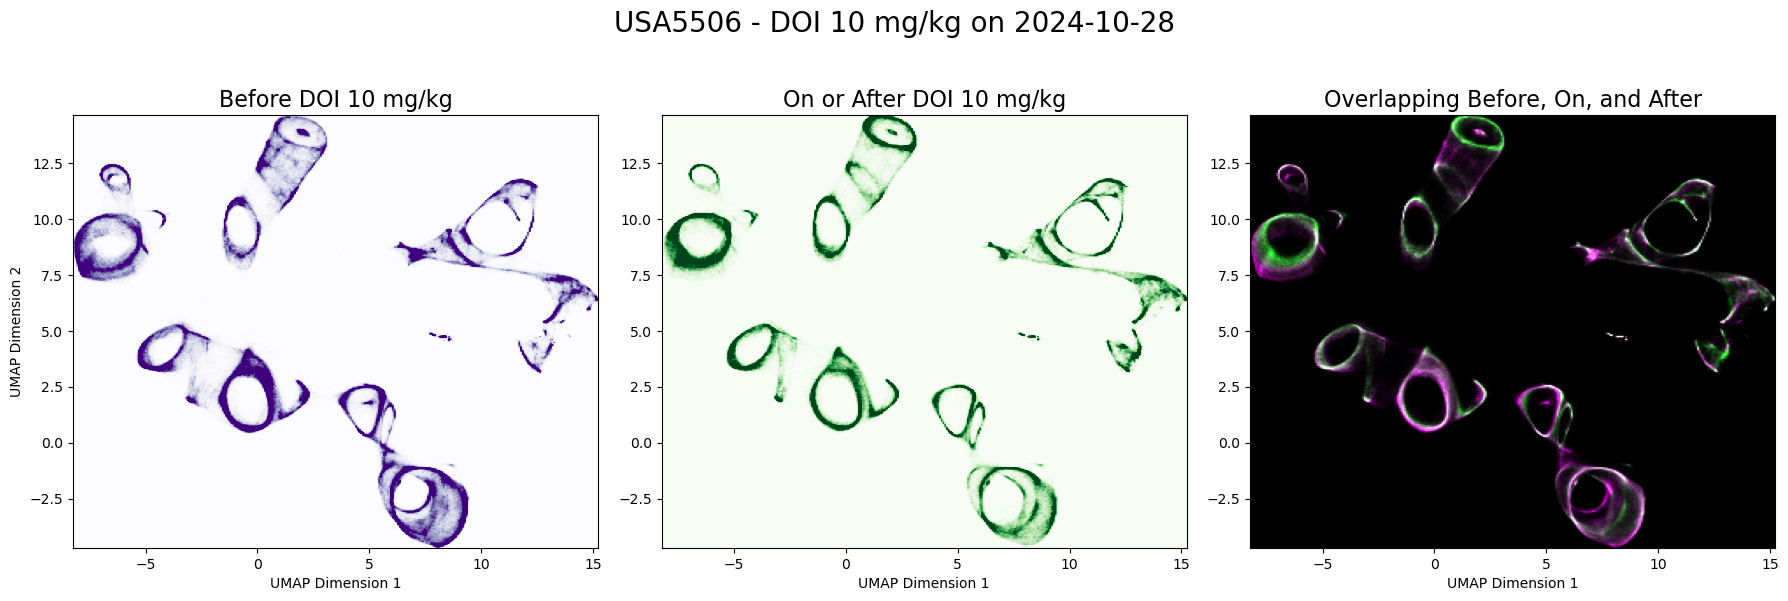

In [7]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# Paths to the .npz and .json files
# path_to_npz_file_from_TweetyBERT = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508.npz'
# path_to_json_file_with_dates = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508_creation_data.json'

# Extract the animal ID using regex
match = re.search(r"(USA\d{4})", path_to_npz_file_from_TweetyBERT)
if match:
    animal_id = match.group(1)
    print(f"Animal ID: {animal_id}")
else:
    print("Animal ID not found in the file path.")

# Load the JSON file and extract treatment details
with open(path_to_json_file_with_dates, 'r') as file:
    json_data = json.load(file)

treatment_date_str = json_data.get("treatment_date", "Treatment date not found")
treatment_type = json_data.get("treatment_type", "Treatment type not found")
print(f"Treatment Date: {treatment_date_str}")
print(f"Treatment Type: {treatment_type}")

# Convert treatment date to datetime
treatment_date = pd.to_datetime(treatment_date_str)

# Assuming 'final_df' is your DataFrame with 'Date' and 'Coordinate' columns
final_df['Date'] = pd.to_datetime(final_df['Date'])

# Split 'Coordinate' column into 'X' and 'Y'
coordinates = pd.DataFrame(final_df['Coordinate'].tolist(), columns=['X', 'Y'])
final_df[['X', 'Y']] = coordinates

# Filter coordinates based on treatment date
before_treatment = final_df[final_df['Date'] < treatment_date]
after_treatment = final_df[final_df['Date'] >= treatment_date]

# Define bins for the heatmap
bins = 300

# Create a 2D histogram for data before treatment
heatmap_before, xedges, yedges = np.histogram2d(before_treatment['X'], before_treatment['Y'], bins=bins)

# Create a 2D histogram for data after treatment
heatmap_after, _, _ = np.histogram2d(after_treatment['X'], after_treatment['Y'], bins=[xedges, yedges])

# Normalize each heatmap independently
heatmap_before = heatmap_before / heatmap_before.max()
heatmap_after = heatmap_after / heatmap_after.max()

# Create an RGB image with purple and green channels for overlap visualization
rgb_image = np.zeros((heatmap_before.shape[0], heatmap_before.shape[1], 3))
# Increase the intensity of the RGB channels
brightness_factor = 4  # Adjust this value as needed to make the colors brighter
rgb_image[..., 0] = np.clip(heatmap_before.T * brightness_factor, 0, 1)  # Red channel for purple
rgb_image[..., 1] = np.clip(heatmap_after.T * brightness_factor, 0, 1)   # Green channel for green
rgb_image[..., 2] = np.clip(heatmap_before.T * brightness_factor, 0, 1)  # Blue channel for purple


# Plot the two heatmaps separately and the combined RGB plot
plt.figure(figsize=(18, 6))

# Plot for data before treatment
plt.subplot(1, 3, 1)
plt.imshow(heatmap_before.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='Purples', vmax=0.1)
plt.title(f"Before {treatment_type}", fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

# Plot for data after treatment
plt.subplot(1, 3, 2)
plt.imshow(heatmap_after.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='Greens', vmax=0.1)
plt.title(f"On or After {treatment_type}", fontsize=16)
plt.xlabel('UMAP Dimension 1')

# Plot combined RGB image
plt.subplot(1, 3, 3)
plt.imshow(rgb_image, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower')
plt.title("Overlapping Before, On, and After", fontsize=16)
plt.xlabel('UMAP Dimension 1')

# Main title and layout
plt.suptitle(f"{animal_id} - {treatment_type} on {treatment_date_str}", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

## For the third plot, multiply the points' colors by a brightness factor to make them easier to see.  Adjust the brightness factor in line 64 as needed.

Animal ID: USA5506
Treatment Date: 2024-10-28
Treatment Type: DOI 10 mg/kg


/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_90670/2436886835.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Date'] = pd.to_datetime(final_df['Date'])
/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_90670/2436886835.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[['X', 'Y']] = coordinates


Number of data points before treatment: 626247
Number of data points on or after treatment: 373753


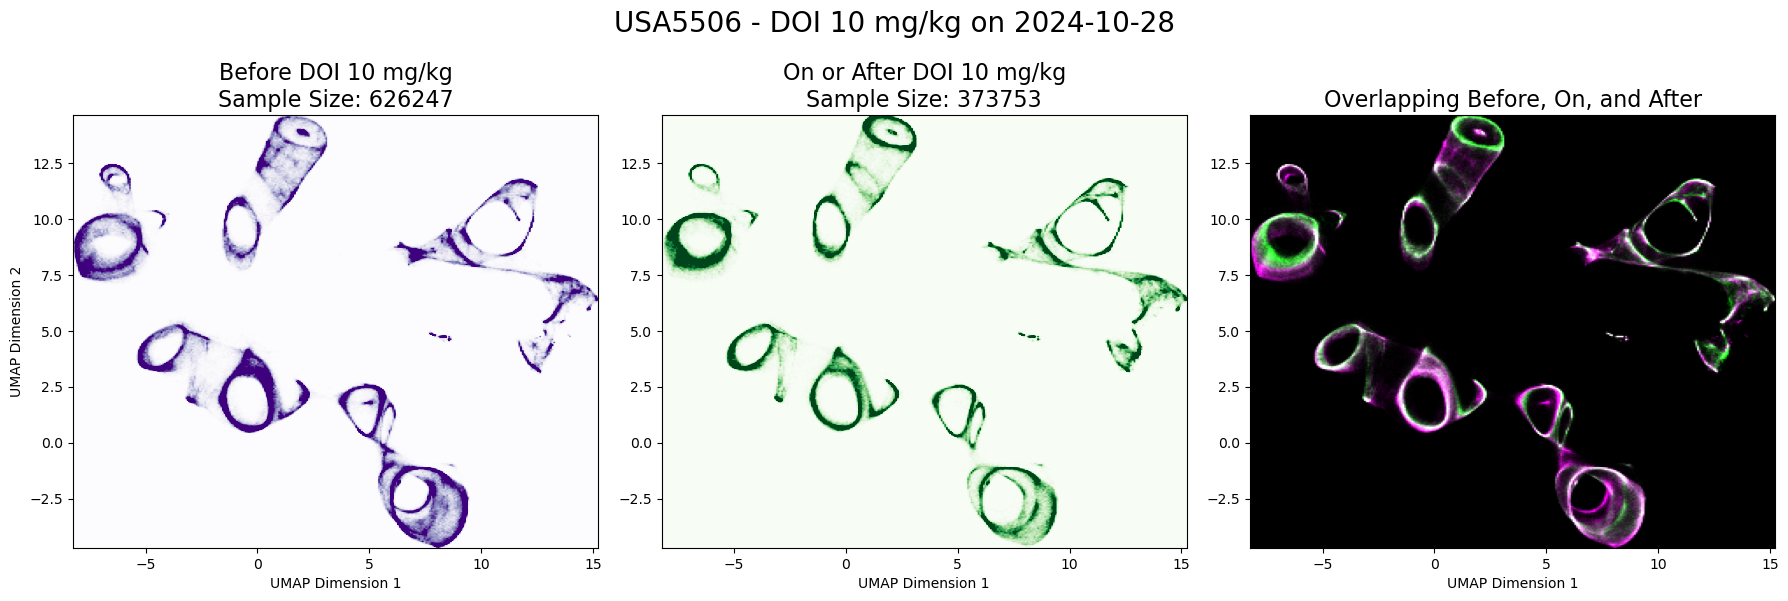

In [8]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# Paths to the .npz and .json files
# path_to_npz_file_from_TweetyBERT = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508.npz'
# path_to_json_file_with_dates = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508_creation_data.json'

# Extract the animal ID using regex
match = re.search(r"(USA\d{4})", path_to_npz_file_from_TweetyBERT)
if match:
    animal_id = match.group(1)
    print(f"Animal ID: {animal_id}")
else:
    print("Animal ID not found in the file path.")

# Load the JSON file and extract treatment details
with open(path_to_json_file_with_dates, 'r') as file:
    json_data = json.load(file)

treatment_date_str = json_data.get("treatment_date", "Treatment date not found")
treatment_type = json_data.get("treatment_type", "Treatment type not found")
print(f"Treatment Date: {treatment_date_str}")
print(f"Treatment Type: {treatment_type}")

# Convert treatment date to datetime
treatment_date = pd.to_datetime(treatment_date_str)

# Assuming 'final_df' is your DataFrame with 'Date' and 'Coordinate' columns
final_df['Date'] = pd.to_datetime(final_df['Date'])

# Split 'Coordinate' column into 'X' and 'Y'
coordinates = pd.DataFrame(final_df['Coordinate'].tolist(), columns=['X', 'Y'])
final_df[['X', 'Y']] = coordinates

# Filter coordinates based on treatment date
before_treatment = final_df[final_df['Date'] < treatment_date]
after_treatment = final_df[final_df['Date'] >= treatment_date]

# Print the number of datapoints for each dataset
num_before = len(before_treatment)
num_after = len(after_treatment)
print(f"Number of data points before treatment: {num_before}")
print(f"Number of data points on or after treatment: {num_after}")

# Define bins for the heatmap
bins = 300

# Create a 2D histogram for data before treatment
heatmap_before, xedges, yedges = np.histogram2d(before_treatment['X'], before_treatment['Y'], bins=bins)

# Create a 2D histogram for data after treatment
heatmap_after, _, _ = np.histogram2d(after_treatment['X'], after_treatment['Y'], bins=[xedges, yedges])

# Normalize each heatmap independently
heatmap_before = heatmap_before / heatmap_before.max()
heatmap_after = heatmap_after / heatmap_after.max()

# Create an RGB image with purple and green channels for overlap visualization
rgb_image = np.zeros((heatmap_before.shape[0], heatmap_before.shape[1], 3))
# Increase the intensity of the RGB channels
brightness_factor = 6  # Adjust this value as needed to make the colors brighter
rgb_image[..., 0] = np.clip(heatmap_before.T * brightness_factor, 0, 1)  # Red channel for purple
rgb_image[..., 1] = np.clip(heatmap_after.T * brightness_factor, 0, 1)   # Green channel for green
rgb_image[..., 2] = np.clip(heatmap_before.T * brightness_factor, 0, 1)  # Blue channel for purple

# Plot the two heatmaps separately and the combined RGB plot
plt.figure(figsize=(18, 6))

# Plot for data before treatment
plt.subplot(1, 3, 1)
plt.imshow(heatmap_before.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='Purples', vmax=0.1)
plt.title(f"Before {treatment_type}\nSample Size: {num_before}", fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

# Plot for data after treatment
plt.subplot(1, 3, 2)
plt.imshow(heatmap_after.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='Greens', vmax=0.1)
plt.title(f"On or After {treatment_type}\nSample Size: {num_after}", fontsize=16)
plt.xlabel('UMAP Dimension 1')

# Plot combined RGB image
plt.subplot(1, 3, 3)
plt.imshow(rgb_image, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower')
plt.title("Overlapping Before, On, and After", fontsize=16)
plt.xlabel('UMAP Dimension 1')

# Main title and layout
plt.suptitle(f"{animal_id} - {treatment_type} on {treatment_date_str}", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()
